In [1]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from nltk.stem import PorterStemmer, WordNetLemmatizer
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import classification_report, accuracy_score
import transformers
from transformers import pipeline
import spacy
from spacy import displacy, tokenizer
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [2]:
import pandas as pd

In [33]:
data = pd.read_csv("news_dataset.csv")

In [34]:
data = data.dropna(subset=['text']).reset_index(drop=True)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3721 entries, 0 to 3720
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3721 non-null   object
 1   text    3721 non-null   object
dtypes: object(2)
memory usage: 58.3+ KB


In [36]:
data.head()

,label,text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...
1,FAKE,A four-minute-long video of a woman criticisin...
2,FAKE,"Republic Poll, a fake Twitter account imitatin..."
3,REAL,"Delhi teen finds place on UN green list, turns..."
4,REAL,Delhi: A high-level meeting underway at reside...


In [37]:
data['punctuation'] = data.apply(lambda x: re.sub(r"[^\w\s]", "", x["text"]), axis = 1)

In [38]:
data['clean_text'] = data['punctuation'].str.lower()

In [16]:
data.head()

,label,text,clean_text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...,payal has accused filmmaker anurag kashyap of ...
1,FAKE,A four-minute-long video of a woman criticisin...,a fourminutelong video of a woman criticising ...
2,FAKE,"Republic Poll, a fake Twitter account imitatin...",republic poll a fake twitter account imitating...
3,REAL,"Delhi teen finds place on UN green list, turns...",delhi teen finds place on un green list turns ...
4,REAL,Delhi: A high-level meeting underway at reside...,delhi a highlevel meeting underway at residenc...


In [10]:
plt.rcParams['figure.figsize'] = (12, 8)
default_plot_colour = "#00bfbf"

In [11]:
nlp = spacy.load("en_core_web_sm")

In [12]:
fake_news = data[data['label'] == 'FAKE']
fact_news = data[data['label'] == 'REAL']

In [13]:
fake_spacydoc = list(nlp.pipe(fake_news['clean_text']))

In [14]:
fact_spacydoc = list(nlp.pipe(fact_news['clean_text']))

In [15]:
def extract_tokens(doc: spacy.tokens.doc.Doc):
    return ([i.text, i.ent_type_, i.pos_] for i in doc)

In [16]:
fake_tagsdf = []
columns = ['tokens', "ner_tag", "pos_tag"]

for ix, doc in enumerate(fake_spacydoc) :
    tags = extract_tokens(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fake_tagsdf.append(tags)

fake_tagsdf = pd.concat(fake_tagsdf)

In [17]:
fact_tagsdf = []
columns = ['tokens', 'ner_tag', 'pos_tag']

for ix, doc in enumerate(fact_spacydoc) :
    tags = extract_tokens(doc)
    tags = pd.DataFrame(tags)
    tags.columns = columns
    fact_tagsdf.append(tags)

fact_tagsdf = pd.concat(fact_tagsdf)

In [18]:
top_entities_fake = fake_tagsdf[fake_tagsdf['ner_tag'] != ''] \
                    .groupby(['tokens', 'ner_tag']).size().reset_index(name = 'counts') \
                    .sort_values(by = 'counts', ascending = False)

top_entities_fact = fact_tagsdf[fact_tagsdf['ner_tag'] != ''] \
                    .groupby(['tokens', 'ner_tag']).size().reset_index(name = 'counts') \
                    .sort_values(by = 'counts', ascending = False)

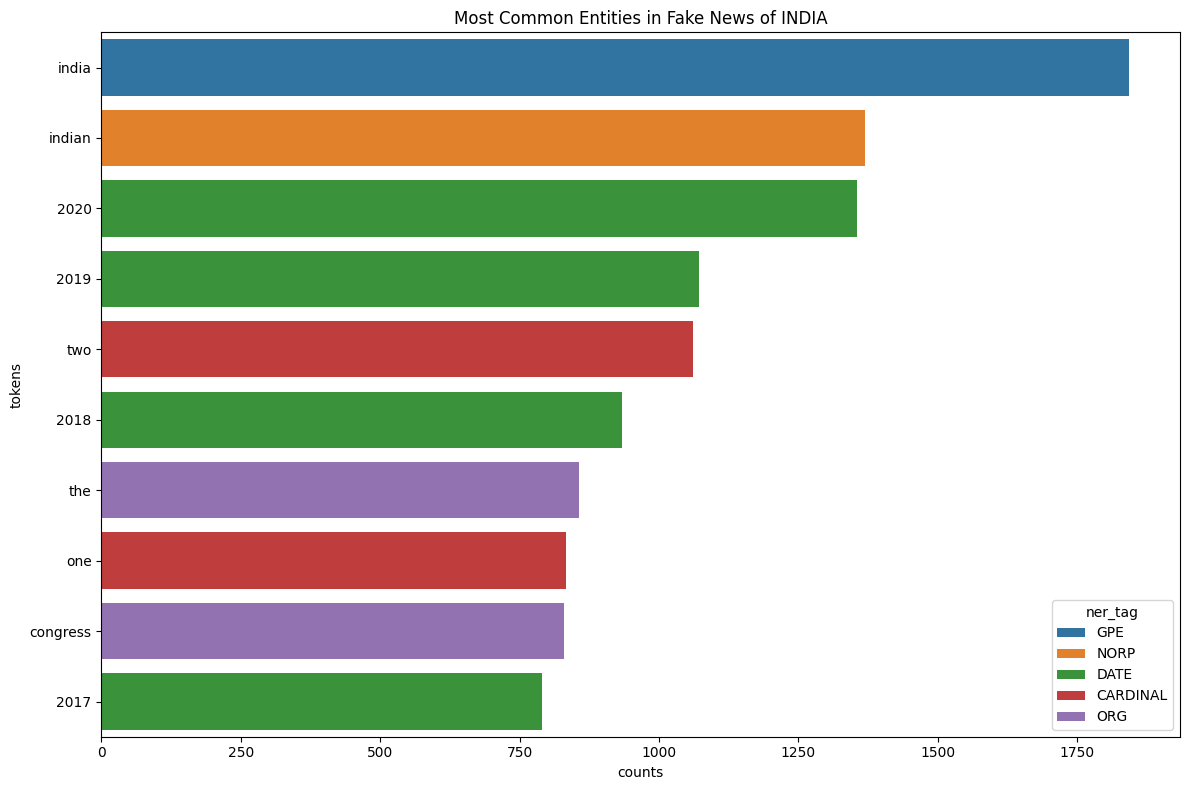

In [19]:
sns.barplot(
    x='counts',
    y='tokens',
    hue='ner_tag',
    data=top_entities_fake.head(10),
    orient='h',
    dodge=False
)
plt.title('Most Common Entities in Fake News of INDIA')
plt.tight_layout()
plt.show()

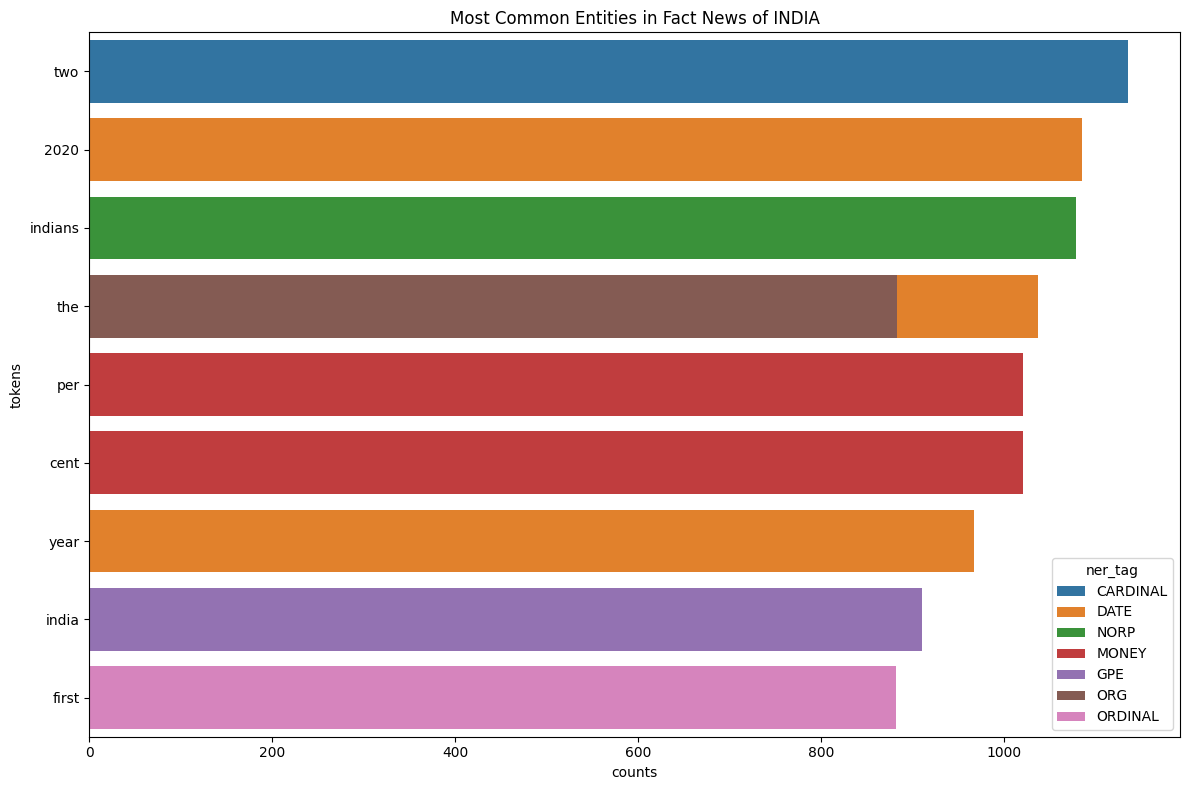

In [20]:
sns.barplot(
    x = "counts",
    y = "tokens",
    hue = "ner_tag",
    data = top_entities_fact.head(10),
    orient = "h",
    dodge = False
)
plt.title("Most Common Entities in Fact News of INDIA")
plt.tight_layout()
plt.show()

In [39]:
en = stopwords.words("english")

data["clean_text"] = data["clean_text"].apply(lambda x: ' '.join(word for word in x.split() if word not in en))

In [40]:
data.head()

,label,text,punctuation,clean_text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...,Payal has accused filmmaker Anurag Kashyap of ...,payal accused filmmaker anurag kashyap behavin...
1,FAKE,A four-minute-long video of a woman criticisin...,A fourminutelong video of a woman criticising ...,fourminutelong video woman criticising governm...
2,FAKE,"Republic Poll, a fake Twitter account imitatin...",Republic Poll a fake Twitter account imitating...,republic poll fake twitter account imitating a...
3,REAL,"Delhi teen finds place on UN green list, turns...",Delhi teen finds place on UN green list turns ...,delhi teen finds place un green list turns gla...
4,REAL,Delhi: A high-level meeting underway at reside...,Delhi A highlevel meeting underway at residenc...,delhi highlevel meeting underway residence raj...


In [41]:
data["clean_text"] = data.apply(lambda x: word_tokenize(x["clean_text"]), axis = 1)

In [42]:
lm = WordNetLemmatizer()
data['clean_text'] = data["clean_text"].apply(lambda x: [lm.lemmatize(token) for token in x])

In [21]:
data.head()

,label,text,clean_text
0,REAL,Payal has accused filmmaker Anurag Kashyap of ...,"[payal, accused, filmmaker, anurag, kashyap, b..."
1,FAKE,A four-minute-long video of a woman criticisin...,"[fourminutelong, video, woman, criticising, go..."
2,FAKE,"Republic Poll, a fake Twitter account imitatin...","[republic, poll, fake, twitter, account, imita..."
3,REAL,"Delhi teen finds place on UN green list, turns...","[delhi, teen, find, place, un, green, list, tu..."
4,REAL,Delhi: A high-level meeting underway at reside...,"[delhi, highlevel, meeting, underway, residenc..."


In [23]:
tokens_clean = sum(data["clean_text"], [])

unigrams = (pd.Series(nltk.ngrams(tokens_clean, 1)).value_counts().reset_index()[:10])

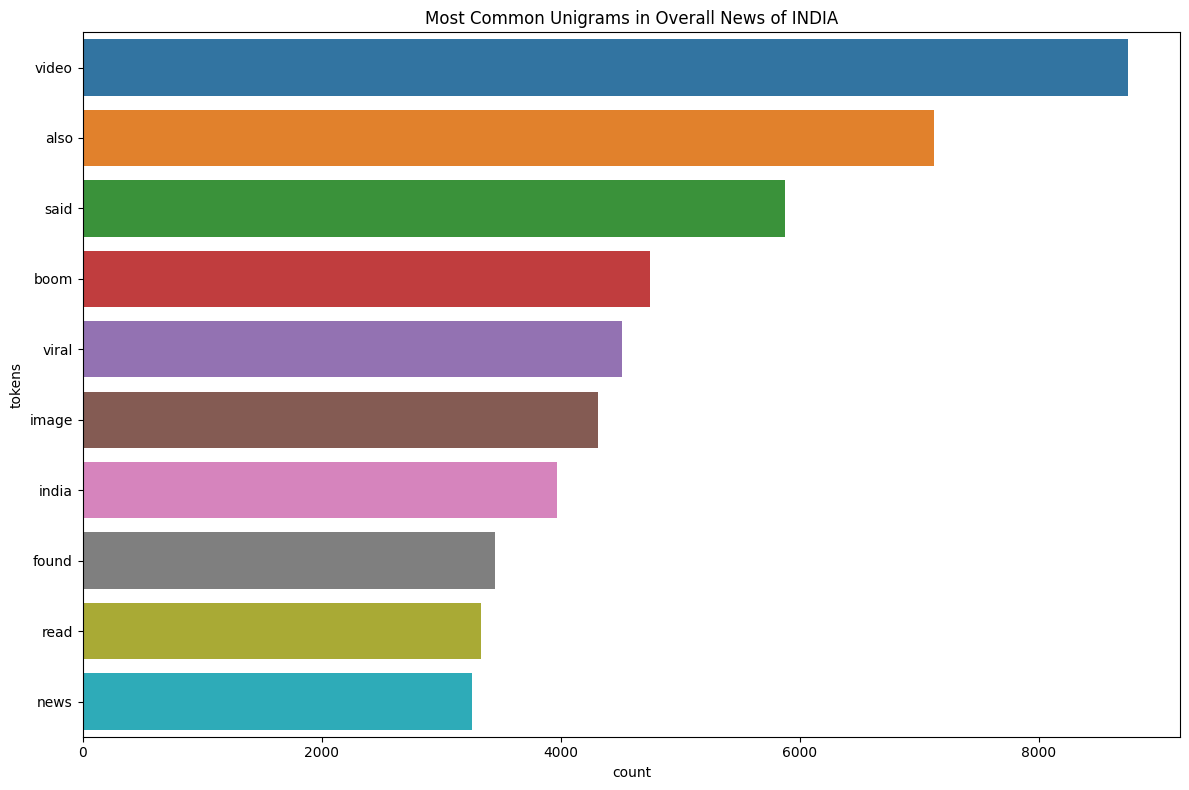

In [24]:
unigrams['tokens'] = unigrams['index'].apply(lambda x: x[0])

sns.barplot(
    x = "count", 
    y = "tokens",
    data = unigrams,
    orient = 'h',
    hue = "tokens",
    legend = False
)
plt.title("Most Common Unigrams in Overall News of INDIA")
plt.tight_layout()
plt.show()

In [25]:
vs = SentimentIntensityAnalyzer()

In [43]:
data['vsentiment'] = data['punctuation'].apply(lambda x: vs.polarity_scores(x)['compound'])

In [44]:
bins = [-1, -0.1, 0.1, 1]
names = ['neative', 'neutral', 'positive']

In [45]:
data['vs_label'] = pd.cut(data['vsentiment'], bins, labels = names)

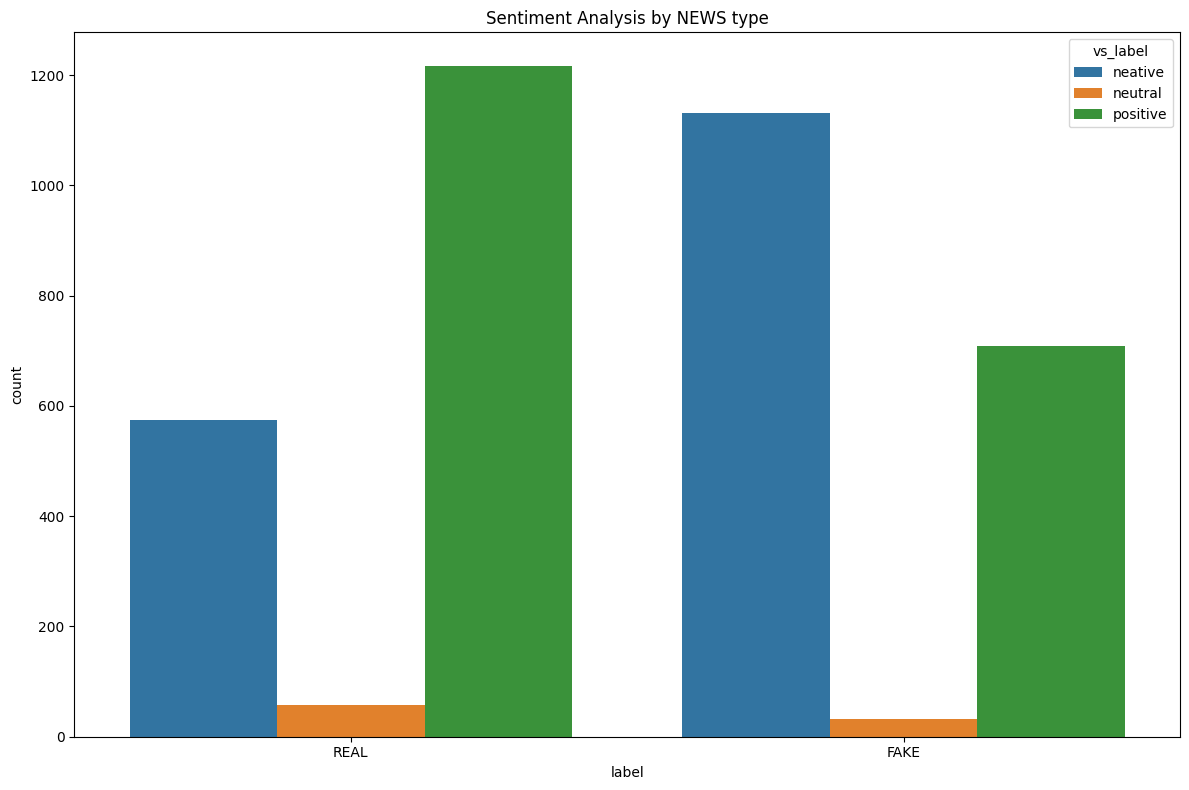

In [47]:
sns.countplot(
    x = 'label',
    hue = 'vs_label',
    data = data
)
plt.title("Sentiment Analysis by NEWS type")
plt.tight_layout()
plt.show()

In [48]:
X = [','.join(map(str, l)) for l in data['clean_text']]

In [49]:
Y = data['label']

In [52]:
cv = CountVectorizer()
cv_fit = cv.fit_transform(X)
bag_o_words = pd.DataFrame(cv_fit.toarray(), columns = cv.get_feature_names_out())

In [53]:
X_train, X_test, Y_train, Y_test = train_test_split(bag_o_words, Y, test_size = 0.3)

In [54]:
lr = LogisticRegression(random_state = 0).fit(X_train, Y_train)

In [55]:
y_pred_lr = lr.predict(X_test)

In [56]:
accuracy_score(y_pred_lr, Y_test)

0.9964189794091316

In [57]:
print(classification_report(Y_test, y_pred_lr))

              precision    recall  f1-score   support

        FAKE       1.00      0.99      1.00       554
        REAL       0.99      1.00      1.00       563

    accuracy                           1.00      1117
   macro avg       1.00      1.00      1.00      1117
weighted avg       1.00      1.00      1.00      1117



In [60]:
svm = SGDClassifier(random_state = 0).fit(X_train, Y_train)

In [61]:
y_pred_svm  = svm.predict(X_test)

In [62]:
accuracy_score(y_pred_lr, Y_test)

0.9964189794091316

In [63]:
print(classification_report(Y_test, y_pred_lr))

              precision    recall  f1-score   support

        FAKE       1.00      0.99      1.00       554
        REAL       0.99      1.00      1.00       563

    accuracy                           1.00      1117
   macro avg       1.00      1.00      1.00      1117
weighted avg       1.00      1.00      1.00      1117

